# Data Analysis Interview Challenge

## Table of Contents 
1. Load Data and Packages
2. Exploratory Data Analysis (EDA)
3. Experiment and Design Metrics
4. Predictive Modeling 
5. Summary and Conclusions

## Load Data and Packages

In [282]:
# accessing directory and os settings
import os
import sys 

# handling for and manipulation of arrays and dataframes
import numpy as np
import pandas as pd

# handling json files/data
import json

# data and time handling
import time
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

# use os to get path
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

C:\Users\Hailey\Documents\GitHub\CodingChallenges


In [247]:
# set data paths
logins_data_path = os.path.join(PROJ_ROOT, 'UltimateChallenge', 'data', 'logins.json')
udc_data_path = os.path.join(PROJ_ROOT, 'UltimateChallenge', 'data', 'ultimate_data_challenge.json')

# read in data
data = pd.read_json(logins_data_path)
print(data.head())
df = pd.read_json(udc_data_path)
print(df.head())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Andr

In [248]:
# convert to pandas datatime data 
data['login_time'] = pd.to_datetime(data.login_time)
# create/initialize count column
data['count'] = 1
#set login_time as index
data.index = data['login_time']
data.head()

,login_time,count
login_time,,
1970-01-01 20:13:18,1970-01-01 20:13:18,1
1970-01-01 20:16:10,1970-01-01 20:16:10,1
1970-01-01 20:16:37,1970-01-01 20:16:37,1
1970-01-01 20:16:36,1970-01-01 20:16:36,1
1970-01-01 20:26:21,1970-01-01 20:26:21,1


In [249]:
# convert appropriate columns to datetime
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

# find retention length for drivers
df['retention_days'] = df.last_trip_date - df.signup_date
df['retention_days'] = df['retention_days'].astype('timedelta64[D]') 

Above we loaded our data and set up the data to explore in more detail.  During EDA we will visualize the data, look at 15 min intervals of the data, and begin to picure any underlying patterns in the data.  We will also visualize key features in df to better understand retention and activity of drivers.

In [250]:
# check for any null values
print(data.isnull().sum())
print(df.isnull().sum())

login_time    0
count         0
dtype: int64
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
retention_days               0
dtype: int64


There are no missing values in data, but there are some features with missing values in df.  We'll handle these (i.e. populate missing with the mean value) if the features are are important to the later investigation. 

## Exploratory Data Analysis (EDA)

Here we will begin to explore the data with an overarching image of the data and by agglomerating counts of the logins.

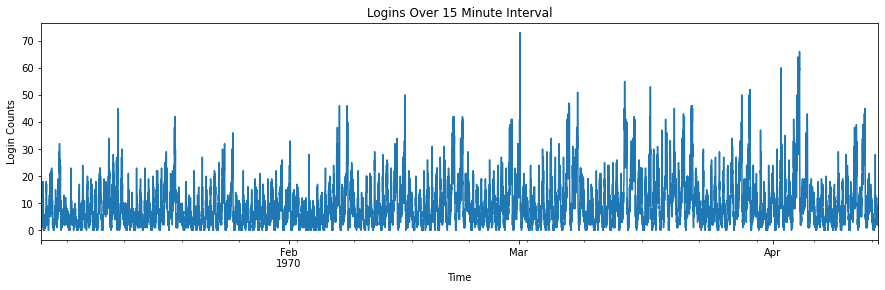

In [251]:
# login counts for 15 min intervals
group_15min = data.login_time.resample('15MIN').count()
# plot the groupings
group_15min.plot(figsize=(15,4))
plt.xlabel('Time')
plt.ylabel('Login Counts')
plt.title('Logins Over 15 Minute Interval');

The plot above shows us 15 minute counts for our data for ~4months.  There are clear osscilations in activity on a both a daily and weekly cycle.  Interestingly, it appears that there are peaks in the login counts cyclically as well.  

It would be good to break out parts of this plot to get a clearer visualization of daily and weekly trends.

In [252]:
# Average Daily Trend Function
# data is the data to go into the function
# interval is the time interval over which to average
# month is the month to be plotted
# day is the day of the month to be plotted.
def data_group(data, interval, month, day):
    # group by interval input and reset index for dataframe manipulation
    data_by_interval = data.groupby([pd.Grouper(key='login_time', 
                                                freq=interval)])['count'].count().reset_index()
    # separate h, m, s
    data_by_interval[['h', 'm', 's']] = pd.DataFrame([(x.hour, x.minute, x.second) 
                                                      for x in data_by_interval['login_time']])
    # get the mean over the interval
    data_interval_mean = data_by_interval.groupby(['h', 'm']).mean().reset_index()
    # rejoin with datetime for visualization
    plot_data_interval = data_interval_mean.merge(data_by_interval, on =['h','m'], how = 'outer')
    
    # subset df for mean counts and login time
    plot_data_interval = plot_data_interval[['count_x', 'login_time']]
    
    # convert to datetime index
    plot_data_interval['login_time'] = pd.to_datetime(plot_data_interval['login_time'])
    plot_data_interval.index = plot_data_interval['login_time']
    # subset to one day of 15 min means
    plot_data_interval_specified_day = plot_data_interval.loc[(plot_data_interval.index.day == day)
                                                              & (plot_data_interval.index.month == month)]
    # plot a day of the average login over 15 min 
    plot_data_interval_specified_day['count_x'].plot(figsize=(15,6))
    plt.xlabel('Time')
    plt.ylabel('Login Counts')
    plt.title('Average Login for {} interval average'.format(interval))
    plt.show()

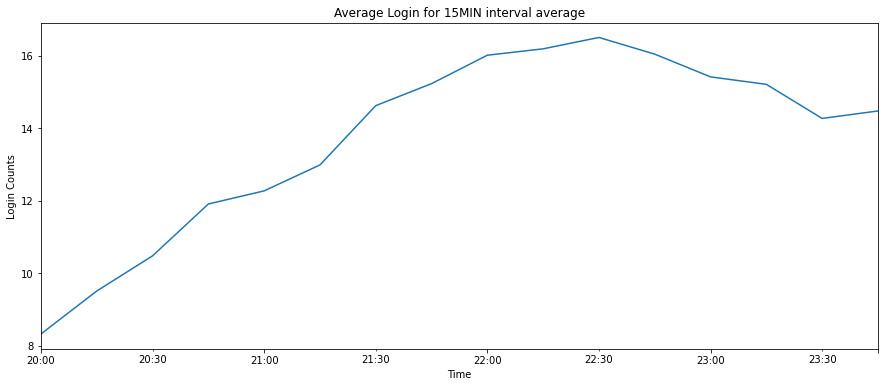

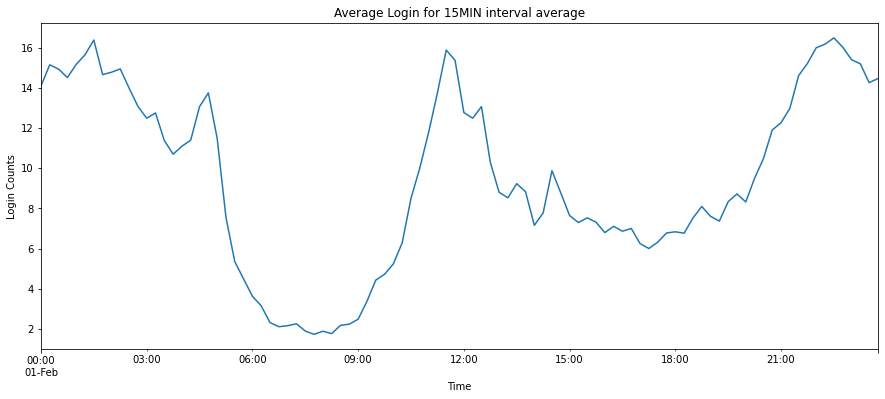

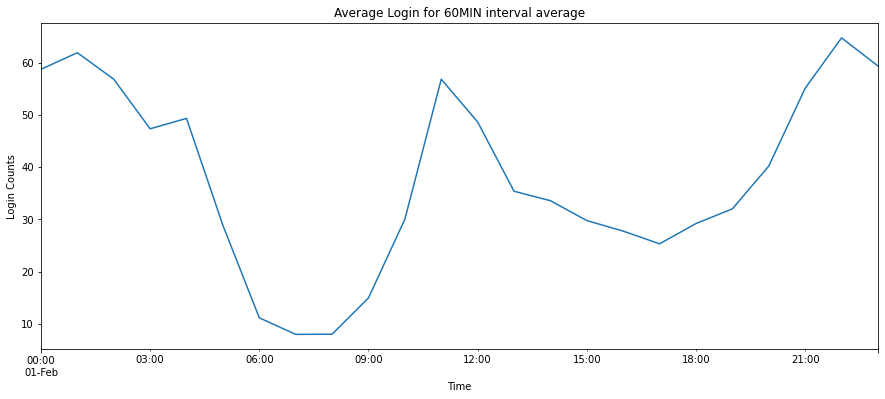

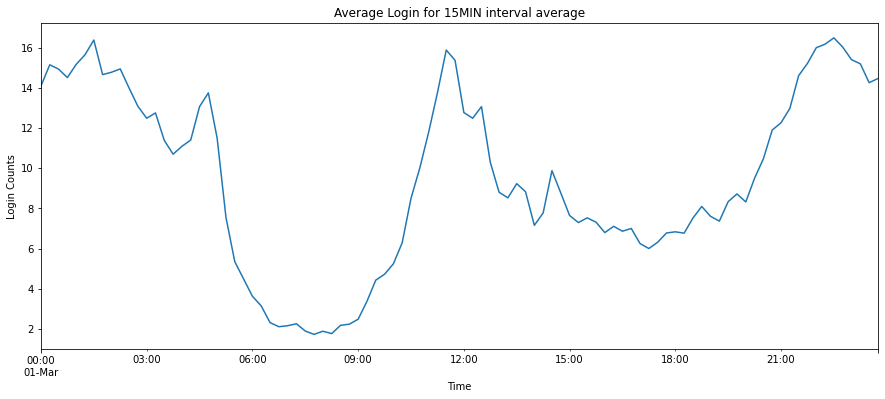

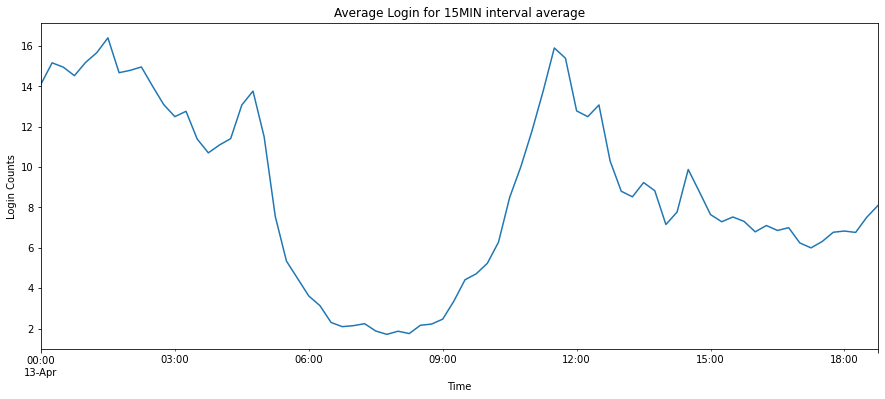

In [253]:
data_group(data=data, interval='15MIN', month=1, day=1)
data_group(data=data, interval='15MIN', month=2, day=1)
data_group(data=data, interval='60MIN', month=2, day=1)
data_group(data=data, interval='15MIN', month=3, day=1)
data_group(data=data, interval='15MIN', month=4, day=13)

Text(0.5, 1.0, 'Counts By Week Day')

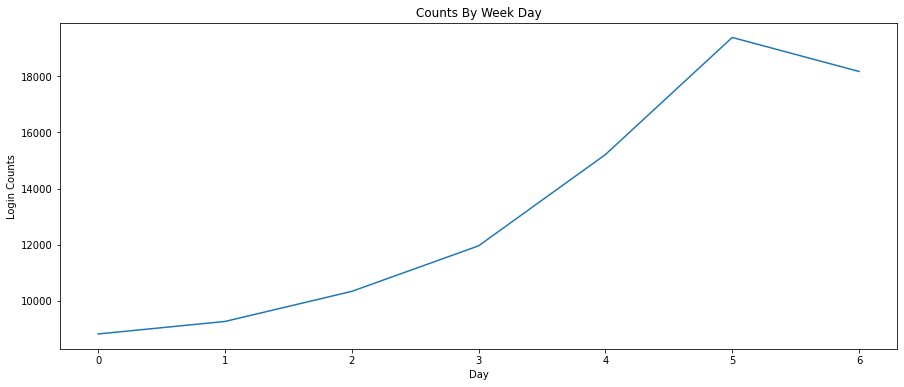

In [254]:
# counts per day mon-sun: 0-6
data_by_interval = data.groupby([pd.Grouper(key='login_time', 
                                           freq=interval)])['count'].count().reset_index()
data_by_interval['weekday'] = data_by_interval['login_time'].dt.dayofweek
data_weekday = data_by_interval.sort_values(by='count')
data_weekday_counts = data_weekday[['count', 'weekday']]
data_weekday_counts = data_weekday_counts.groupby('weekday').sum().reset_index()
# plot the counts per weekday
data_weekday_counts['count'].plot(figsize=(15,6))
plt.xlabel('Day')
plt.ylabel('Login Counts')
plt.title('Counts By Week Day')

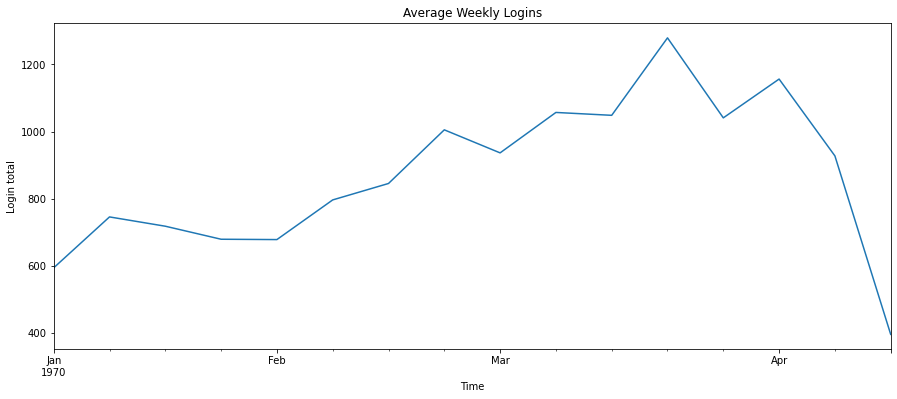

In [255]:
# Average Weekly Trend
# get the daily count of logins 
weekly_count = data.groupby([pd.Grouper(key= 'login_time', 
                                        freq='D')])['count'].count().reset_index()
# create month, day and year columns in dataset
weekly_count[['year', 'month', 'day']] = pd.DataFrame([(x.year, x.month, x.day) 
                                                       for x in weekly_count['login_time']])
# get the mean login count for each week in the dataset
weekly_mean = weekly_count.groupby([pd.Grouper(key='login_time', 
                                               freq='W')])['count'].mean().reset_index()
# create datetime from weekly average 
weekly_mean['login_time'] = pd.to_datetime(weekly_mean['login_time'])
weekly_mean.index = weekly_mean['login_time']

# plot weekly average logins over dataset
weekly_mean['count'].plot(figsize = (15, 6))
plt.xlabel("Time")
plt.ylabel("Login total")
plt.title("Average Weekly Logins")
plt.show()

Herein we see average trends for days and weeks of the dataset.  

The daily trends show peak logins generally occuring during the the morning hours prior to 5am, noon, and the evening hours after 9pm.  There are also more logins at the end of the week, as seen by the counts by week day plot.  

The weekly logins show the weeks with peak login occur at the end of March and beginning of April.  

## Experiment and Design Metrics 

Now that we have looked at the login trends in data, we want to design an experiment considering the information below.

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

* how you will implement the experiment.
* what statistical test(s) you will conduct to verify the significance of the observation.
* how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Some possible measures of how successful reimbursement of toll costs to drivers are
* increase in surge_pct
* increase in weekday_pct
* increase in avg_dist
* increase in retention
* increase in signup_date
Each of the afore mentioned metrics will provide insight on if Ultimate's toll reimbursement program is increasing profitability, however, it is important to note that the increase in profit must be enough to balance the cost of the toll reimbursement.  

Of particular interest for balancing increasing profits and the cost of profitability are the surge_pct and weekday_pct features.  These could be utilized to choose certain times when the tolls are reimbursed.  Increases in these measures mean more profitability, but if the increase in these features occurs only on certain days or at certain times, then this information could be utilized to select when tolls should be reimbursed.

Also of interest is the increase in average distance since it would be of interest to know if the toll reimbursement program results in users traveling farther.  This could indicate that prior to the drivers recieving toll reimbursement, they did not take passengers between cities.  Alternately, it could indicate that the average distance of users stays the same and that users don't really want to travel between cities (so perhaps there are better incentives than the toll reimbursement).  

Finally, an increase in signups and greater user retention would mean more profitability.

A comparision of the metrics discussed above could be compared between two groups of drivers--those who receive toll reimbursement and those who do not.  After a specified time period, the profits made by those drivers receiving toll reimbursement (minus the cost of reimbursement) could be considered in comparison with drivers not receiving toll reimbursement.  

After collecting results, significance of any profit difference between the groups would be determined, however, a threshold should be deterimined prior to this analysis (i.e. an average increase of profits by x amount per driver is acceptable to offset the cost of reimbursement and add to revenue stream).  A threshold should be determined before hand in order to avoid a random acceptance criteria that may or may not ultimately work for the Ultimate.  

The results of the experiment will provide insight on if toll reimbursement increases profitability.  It will also allow for the comparison of improtant dataset features which provide information on usage.  For example, if we were to find that toll reimbursement reduces retention that would be a red flag that we would want to follow up on to better understand why drivers do not like this program (Do they not like driving between the two cities or is something else going on?).  On the other hand, if we see increases in avgerage distances traveled and the percent of trips taken, this would be a very good sign that there is a positive influence on profits.

## Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

### Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Initial cleaning and dataframe preperation was performed above.  Below is futher EDA and visualization.

In [256]:
# impute missing values discovered above
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retention_days          50000 non-null  float6

We now have a dataframe with no missing values and expected data types.  

We can now begin some visualization to better understand the variables and determine how they relate to the retention. 

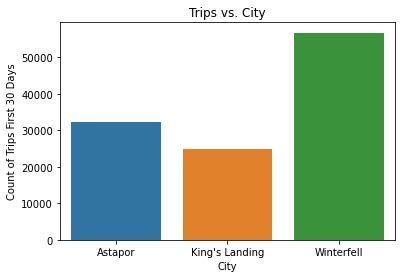

In [257]:
# Create dataframe for city and trips
trips_city = (df[['trips_in_first_30_days', 'city']].groupby('city').sum().reset_index())
# trips_city
# plot data
sns.barplot(x='city', y='trips_in_first_30_days', data=trips_city)
plt.ylabel('Count of Trips First 30 Days')
plt.xlabel('City')
plt.title('Trips vs. City');

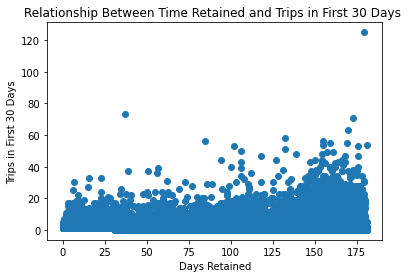

In [258]:
# look retention_days vs trips in first 30 days
plt.scatter(df.retention_days, df.trips_in_first_30_days)
plt.xlabel("Days Retained")
plt.ylabel("Trips in First 30 Days")
plt.title("Relationship Between Time Retained and Trips in First 30 Days ")
plt.show()

Users Retained: 18804
Users Not Retained: 31196
Fraction Retained: 0.37608


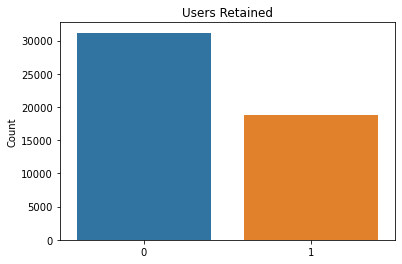

In [259]:
# create bool of retained
df['retained'] = 0
#df['retained'] = df['retained'].astype('bool')
# cutoff for retention
cutoff = df['last_trip_date'].max() - pd.Timedelta(days = 30)
#set retained to 1
df.loc[df['last_trip_date'] >= cutoff, 'retained'] = 1
# get counts to calculate fraction
retained_count = len(df.loc[df['retained'] == 1])
not_retained_count = len(df.loc[df['retained'] == 0])
# print retention info.
fraction_retained = retained_count/ (retained_count + not_retained_count)
print ("Users Retained: {}\nUsers Not Retained: {}\nFraction Retained: {}".format(retained_count, not_retained_count, fraction_retained))

#plot retained, not retained
objects = ('Retained', 'Not Retained')
sns.barplot(np.arange(len(objects)), df['retained'].value_counts())
plt.ylabel('Count')
plt.title('Users Retained')
plt.show()

For any values of interest, a plot may be created such as those above.  

To move towards creating a model, the datetime variables should be dropped object variables should be one hot encoded.

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retention_days          50000 non-null  float6

In [262]:
# drop datetime columns
#df = df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
df.drop('last_trip_date', axis=1, inplace=True)
df.drop('signup_date', axis=1, inplace=True)

In [267]:
# save retained values for later and drop them from rest of data.
y = df.retained.values

df.drop('retained', axis=1, inplace=True)
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention_days
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,143.0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,96.0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,1.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,170.0
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,47.0


In [268]:
# one hot encode
df_encoded = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
df_encoded.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention_days,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,143.0,0,1,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,96.0,1,0,0,1,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1.0,1,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,170.0,0,1,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,47.0,0,0,1,1,0,1,0


In [269]:
# use customary annotation for features -- X
X = df_encoded.values
X[0]

array([  4.  ,   4.7 ,   1.1 ,  15.4 ,  46.2 ,   3.67,   5.  , 143.  ,
         0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   0.  ,   1.  ])

Now that we have prepared the data, we can split it into training and test sets.  Due to the variation in feature scale, scaling should be implemented.  Then the data can be fit to the model and finally, classifications can be made.

In [273]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [274]:
# scale the X features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Here we will create a neural network(nn) with TensorFlow and Keras to preform our classification.  In this case, the nn will create a good model because we can create layers to take each input and hidden layers to perform weighting for each individual feature. 

In [278]:
# initialize nn 
classifier = Sequential()

# create input layer and first hidden layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
# add second hidden layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu'))
# add output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

Above, the input layer accepts 15 inputs with 7 neurons.  The number of neurons was choosen from the average between input and output counts.  The hidden layers utilize the rectifier activation function since it is a general function.  The output layer uses the sigmoid function to find the probability for the final layer.  

Finally, the Adam optimizer will be used to compile the nn. 

In [279]:
# Compile nn 
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Next, we will fit the nn to the compiled classifier 

In [280]:
# fit to training set
classifier.fit(X_train, y_train, batch_size = 16, epochs = 10)


Epoch 1/10
37500/37500 [==============================] - 2s 55us/step - loss: 0.1837 - accuracy: 0.9222
Epoch 2/10
37500/37500 [==============================] - 2s 52us/step - loss: 0.0940 - accuracy: 0.9588
Epoch 3/10
37500/37500 [==============================] - 2s 48us/step - loss: 0.0931 - accuracy: 0.9584
Epoch 4/10
37500/37500 [==============================] - 2s 50us/step - loss: 0.0927 - accuracy: 0.9585
Epoch 5/10
37500/37500 [==============================] - 2s 50us/step - loss: 0.0923 - accuracy: 0.9590
Epoch 6/10
37500/37500 [==============================] - 2s 51us/step - loss: 0.0925 - accuracy: 0.9589
Epoch 7/10
37500/37500 [==============================] - 2s 54us/step - loss: 0.0922 - accuracy: 0.9589
Epoch 8/10
37500/37500 [==============================] - 2s 54us/step - loss: 0.0920 - accuracy: 0.9591
Epoch 9/10
37500/37500 [==============================] - 2s 53us/step - loss: 0.0919 - accuracy: 0.9591
Epoch 10/10
37500/37500 [=============================

###### The model has a 95.91% accuracy and minimal loss

Now that we have a well-performing model, we will predict the retention rate where above 50% is True.  If we needed more sensitivity, we would want to use a higher threshold.

In [283]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[7490  318]
 [ 209 4483]]


The confusion matrix above shows (on the diagonal) that the majority of the classifications were accurate. 

In [284]:
# break types out of confusion matrix
pos, neg = cm
tp, fp = pos
fn, tn = neg

# accuracy of prediction
acc = (tp+tn)/(tp+tn+fp+fn)
print('Accuracy: ', acc)

Accuracy:  0.95784


From the confusion matrix, we see we have a 95.78% accuracy which is very similar to the accuracy on the training data.  

In [322]:
retained = pd.DataFrame(y)
retained.columns = ['retained']
pd.concat([df_encoded, retained],
          axis=1).corr().iloc[14].sort_values(
    ascending=False)

ultimate_black_user_True     1.000000
retained                     0.205002
retention_days               0.165035
trips_in_first_30_days       0.112210
phone_iPhone                 0.075836
city_King's Landing          0.039649
weekday_pct                  0.035998
avg_dist                     0.032310
city_Astapor                 0.021259
avg_rating_by_driver         0.009328
avg_rating_of_driver        -0.001916
city_Winterfell             -0.051990
phone_Android               -0.075836
avg_surge                   -0.078791
surge_pct                   -0.106861
ultimate_black_user_False   -1.000000
Name: ultimate_black_user_True, dtype: float64


## Summary and Conclusions

### Summay 

Herein we performed EDA, some minor data cleaning, and created a model.  

Our initial model performed very well so we did not need to do any tuning in this case.  However, if we had a model that did not perform as well, we would want to iterate on this step until we had a better tuned model.  

### Conclusions

Ultimate might leverage the insights gained from the model to improve its longterm rider retention by looking at features of an example user and how they creating incentive programs that improve user's likelihood of retention.  For example, below is a sample user and the prediction of their likelihood to be retained after 6 months.

In [320]:
ex_user = pd.DataFrame([0.  ,   3.  ,   0.6  ,   0.  , 100.  ,   4.28,   5.9 , 137.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0. ])
ex_user = ex_user.T
ex_user.columns = df_encoded.columns
ex_user

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retention_days,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.0,3.0,0.6,0.0,100.0,4.28,5.9,137.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [321]:
# Making prediction for given values
new_prediction = classifier.predict(
    sc.transform(np.array(ex_user.values)))
new_prediction_tf = (new_prediction > 0.5)
print('Customer will be retained:', new_prediction_tf, new_prediction)

Customer will be retained: [[False]] [[0.45614675]]


In the example above, the customer is not likely to be retained, but by playing with the average surge and increasing it by just 0.1, the customer is more likely to be retained.  While this is just a probability, and there is a chance that the customer will still not be retained, the likelihood is that any incentive that would increase this customer's surge value would result in better chance of retention.  Thus, this model can be used to inform how to apply marketing campaigns or rewards systems.

The features that Ultimate should consider for such campaigns/systems are trips_in_first_30_days, phone_iPhone, and city_King's Landing as they have high correlation to retention.  Incentivizing trips during the first 30 days, performing platform usability studies between iphon and android, and getting user behaviour surveys to determine what is done well in King's Landing would all be good steps to improving retention.

### Watermark

In [323]:
# use watermark in a notebook with the following call
%load_ext watermark

# %watermark? #<-- watermark documentation

%watermark -a "H.GRYK" -d -t -v -p sys
%watermark -p numpy
%watermark -p pandas
%watermark -p matplotlib
%watermark -p seaborn
%watermark -p json
%watermark -p statsmodels
%watermark -p sklearn
%watermark -p keras
%watermark -p tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
H.GRYK 2020-10-27 14:33:19 

CPython 3.7.7
IPython 7.18.1

sys 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy 1.19.1
pandas 1.0.5
matplotlib 3.3.2
seaborn 0.10.1
json 2.0.9
statsmodels 0.11.1
sklearn 0.23.2
keras 2.3.1
tensorflow 1.14.0
